# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/2322/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle
from collections import defaultdict

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [311]:
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


In [312]:
# Show df_content to get an idea of the data
df_content.article_id.nunique(), df.article_id.nunique()

(1051, 714)

In [313]:
df_content.article_id.max(), df.article_id.max()

(1050, 1444.0)

Doesn't look right here, some tests will probably fail as there are article_ids in the df (interactions) 
table that are missing in the df_contents table

### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [314]:
# Users who read most books
df.groupby('email')['article_id'].size().sort_values(ascending=False).head(5)


email
2b6c0f514c2f2b04ad3c4583407dccd0810469ee    364
77959baaa9895a7e2bdc9297f8b27c1b6f2cb52a    363
2f5c7feae533ce046f2cb16fb3a29fe00528ed66    170
a37adec71b667b297ed2440a9ff7dad427c7ac85    169
8510a5010a5d4c89f5b07baac6de80cd12cfaf93    160
Name: article_id, dtype: int64

It shows the two users that read 364 and 363 books are outliers. We will limit our graph to the [0, 170] interval

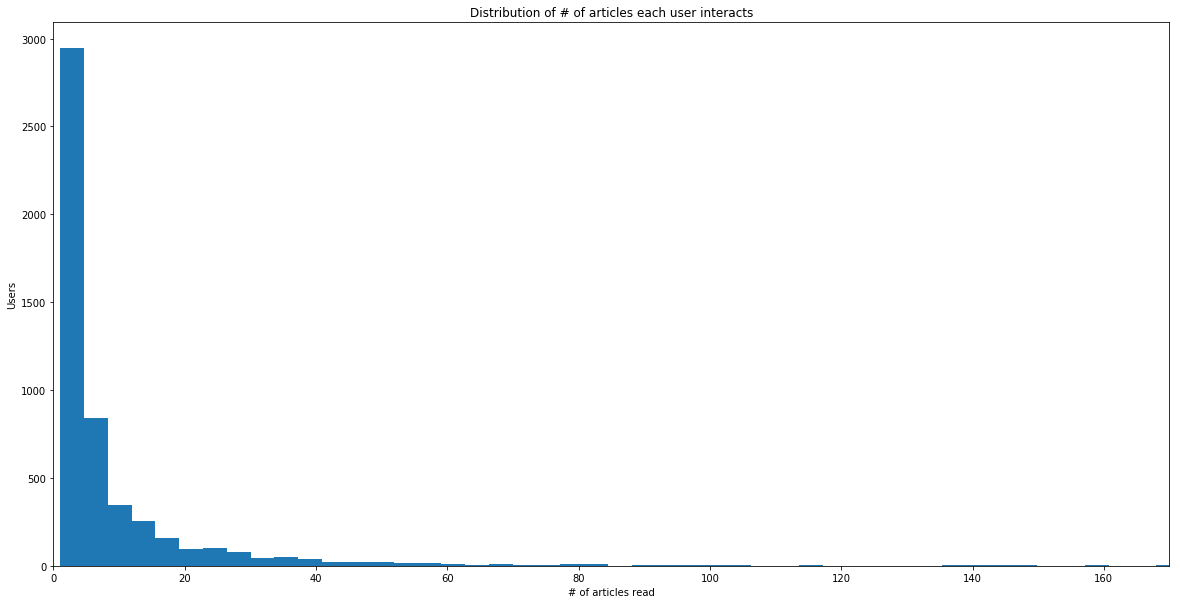

In [315]:
plt.figure(figsize=(20,10))
plt.hist(df.groupby('email')['article_id'].size(), bins=100)
plt.title('Distribution of # of articles each user interacts')
plt.ylabel('Users')
plt.xlabel('# of articles read')
plt.xlim(0,170)
plt.plot();

Clearly a right skewed distribution where everything over 60 is in outlier territory! We can actually calculate the % of users reading more that 60 books...

In [316]:
n_users = df.email.nunique()
user60 = df.groupby('email')['article_id'].size().sort_values(ascending=False)

print("The percentage of users reading more than 60 books is {:0.2f}%".format(100*user60[user60 > 60].size/n_users))

The percentage of users reading more than 60 books is 1.77%


In [317]:
df.groupby(['email']).article_id.nunique().sort_values().mean()

6.54020979020979

In [320]:
df.groupby(['email']).article_id.nunique().sort_values().median(), df.groupby('email')['article_id'].size().sort_values(ascending=False).values[0]

(3.0, 364)

In [321]:
# Fill in the median and maximum number of user_article interactios below
median_val = 3.0 # 50% of individuals interact with ____ number of articles or fewer.
max_views_by_user = 364 # The maximum number of user-article interactions by any 1 user is ______.

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [322]:
# Find and explore duplicate articles
df_content[df_content.duplicated(['article_id'], keep=False)].sort_values(by='article_id')

,doc_body,doc_description,doc_full_name,doc_status,article_id
50,Follow Sign in / Sign up Home About Insight Da...,Community Detection at Scale,Graph-based machine learning,Live,50
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
221,* United States\r\n\r\nIBM® * Site map\r\n\r\n...,When used to make sense of huge amounts of con...,How smart catalogs can turn the big data flood...,Live,221
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
232,Homepage Follow Sign in Get started Homepage *...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232
399,Homepage Follow Sign in Get started * Home\r\n...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
578,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577


In [3]:
# Remove any rows that have the same article_id - only keep the first
def remove_duplicates(df_content):
    '''
    Decscription:
        Remove duplicates from df_content dataframe
    INPUT:
    
    df_content - (pandas dataframe) df_content dataframe
    
    OUTPUT:
    df_content - dataframe with rows that have the same article_id removed
    
    '''
    df_content = df_content.drop_duplicates(subset='article_id', keep='first')
    return df_content

df_content = remove_duplicates(df_content)

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [324]:
df.article_id.nunique(), df_content.article_id.nunique(), df.email.nunique(), df.shape[0]

(714, 1051, 5148, 45993)

In [325]:
unique_articles = 714 # The number of unique articles that have at least one interaction
total_articles = 1051 # The number of unique articles on the IBM platform
unique_users = 5148 # The number of unique users
user_article_interactions = 45993# The number of user-article interactions

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [326]:
df.article_id.value_counts().index[0], df.article_id.value_counts().values[0]

(1429.0, 937)

In [327]:
most_viewed_article_id = "1429.0" # The most viewed article in the dataset as a string with one value following the decimal 
max_views = 937 # The most viewed article in the dataset was viewed how many times?

In [4]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column
def email_mapper(df):
    '''
    Description:
        Convert email column to user_id
    INPUT:
    
    df - (pandas dataframe) df dataframe
    
    OUTPUT:
    df  - dataframe with the user email mapped to a user_id column and  the email column removed
    
    '''
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    
    del df['email']
    df['user_id'] = email_encoded
    
    return df

df = email_mapper(df)

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [329]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [5]:
def get_top_articles(n, df=df):
    '''
    Description:
        Extract titles of top n articles ordered by number of interactions
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    
    top_articles = np.array(df.title.value_counts().index[:n]).astype(str)
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    Description:
        Extract ids of top n articles ordered by number of interactions
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article ids 
    
    '''
    # Your code here
    top_articles = np.array(df.article_id.value_counts().index[:n]).astype(str)
    return top_articles # Return the top article ids

In [331]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification'
 'insights from new york car accident reports'
 'visualize car data with brunel'
 'use xgboost, scikit-learn & ibm watson machine learning apis'
 'predicting churn with the spss random tree algorithm'
 'healthcare python streaming application demo'
 'finding optimal locations of new store using decision optimization'
 'apache spark lab, part 1: basic concepts'
 'analyze energy consumption in buildings'
 'gosales transactions for logistic regression model']
['1429.0' '1330.0' '1431.0' '1427.0' '1364.0' '1314.0' '1293.0' '1170.0'
 '1162.0' '1304.0']


In [332]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [6]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Fill in the function here
    df2 = df.copy()
    df2['rating'] = 1
    user_item = df2.groupby(['user_id', 'article_id'])['rating'].max().unstack()
    user_item.fillna(0, inplace=True)
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [334]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [7]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users:  - (list) user_id  where the closest users (largest dot product users) are listed first
    similar_users_scores: (list) similarity scores of the users                
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    #similarities = pd.Series(np.zeros(user_item.shape[0]), index=user_item.index)
    #for idx, user in user_item.iterrows():
    #    similarities[idx] = np.dot(user_item.loc[user_id], user)
    
    # Actually it is much faster if we multiply by the whole matrix rather than using a for loop
    similarities = pd.Series(np.dot(user_item.loc[user_id], user_item.transpose()), user_item.index)
    
     # remove the own user's id and sort
    similarities.drop(user_id, axis=0, inplace=True)
    similarities.sort_values(ascending=False, inplace=True)
    # create list for ids
    similar_users = similarities.index
    # create list for scores
    similar_users_scores = similarities.values
    
    return  similar_users, similar_users_scores  # return a Series (user_id, similarity_score) of the users in order from most to least similar
        

In [336]:
# Do a spot check of your function

print("The 10 most similar users to user 1 are: {}".format(list(find_similar_users(1)[0][:10])))
print("The 5 most similar users to user 3933 are: {}".format(list(find_similar_users(3933)[0][:5])))
print("The 3 most similar users to user 46 are: {}".format(list(find_similar_users(46)[0][:3])))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 3870, 131, 4201, 46, 3697]
The 5 most similar users to user 3933 are: [1, 3782, 23, 203, 4459]
The 3 most similar users to user 46 are: [4201, 3782, 23]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [8]:
import random

def get_article_names(article_ids, df=df):
    '''
    Description:
        Return the article names associated with list of article ids
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    # Your code here
    # Sometimes they come as strings
    article_ids = np.array(article_ids).astype(float)
    
    article_names = [df[df.article_id == a_id].title.iloc[0] for a_id in article_ids]
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list of strings) a list of the article ids seen by the user
    article_names - (list of strings) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # Your code here
    articles = user_item.loc[user_id]
    articles_ids = np.array(articles[articles==1].index)
    article_names = []
    # need this because the df_content dataframe doesn't have all articles
    for article_id in articles_ids:
        title = df_content[df_content.article_id == article_id].doc_full_name
        if title.any():
            article_names.append(title.values[0])
        else:
            article_names.append("")
    articles_ids = articles_ids.astype(str)
    return articles_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    # Your code here
    recs_ids = []
    # List of articles already seen by the user
    seen_article_ids, _ = get_user_articles(user_id, user_item)
    # get the list of similar users sorted from most similar to least similar and their similarity scores
    most_similar_users, most_similar_users_scores = find_similar_users(user_id, user_item)

    idx = 0
    # Looping through the users: if more than one share same closeness one is chosen arbitrarily
    while ((idx < len(most_similar_users)) and (len(recs_ids) < m)):    
        score = most_similar_users_scores[idx]
        idx_next = idx + 1
        while (score == most_similar_users_scores[idx_next]):
            idx_next += 1    
        next_user = random.randint(idx, idx_next - 1)
        idx = idx_next
        # Finding next user's articles and removing the ones already seen
        user_articles, _ = get_user_articles(most_similar_users[next_user], user_item)
        new_reccs = np.setdiff1d(user_articles, seen_article_ids)
        # Removing the ones already in the recommendation list too
        new_reccs = np.setdiff1d(new_reccs, recs_ids)
        # Adding articles to recommendation list up to max lengtyh
        if (len(recs_ids) + new_reccs.size) < m:
            recs_ids.extend(new_reccs)
        else:
            #random chose articles to add if too many
            recs_ids.extend(random.sample(list(new_reccs), m - len(recs_ids)))
    #print("Extending with user {} by {} articles".format(most_similar_users[next_user], len(new_reccs))) 
    return recs_ids # return your recommendations for this user_id    

In [338]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['54174    detect potentially malfunctioning sensors in r...\nName: title, dtype: object',
 'this week in data science (february 14, 2017)',
 'this week in data science (april 18, 2017)',
 'discover hidden facebook usage insights',
 'using rstudio in ibm data science experience',
 'improving real-time object detection with yolo',
 'deep learning with data science experience',
 'deploy your python model as a restful api',
 'predicting churn with the spss random tree algorithm',
 'optimizing a marketing campaign: moving from predictions to actions']

In [343]:
# Some records don't exist in df_content dataframe so I had to comment out two assertions below
df_content[df_content.doc_full_name=='housing (2015): united states demographic measures']

,doc_body,doc_description,doc_full_name,doc_status,article_id


In [342]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
#assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
#assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [9]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    Description:
        Builds a dataframe of the most similar users to a given user id ordered by similarity score and 
        number of interactiions
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    
    # I'll reuse previous function for neighbors and similarity scores
    users, scores = find_similar_users(user_id)
    neighbors_df = pd.DataFrame(data=scores, index=users, columns=['similarity']).reset_index()
    # Adding interactions column
    neighbors_df['num_interactions'] = neighbors_df.user_id.apply(lambda uid: user_item.loc[uid].sum())
    # Sorting
    neighbors_df = neighbors_df.sort_values(by=['similarity', 'num_interactions'], ascending=False)
    
    return neighbors_df # Return the dataframe specified in the doc_string

def user_user_recs_part2(user_id, m=10, user_item=user_item, df=df):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    # Your code here
    
    recs = []
    # List of articles already seen by the user
    seen_article_ids, _ = get_user_articles(user_id, user_item)
    
    # get the list of similar users sorted from most similar to least similar and their similarity scores
    neighbors_df = get_top_sorted_users(user_id)
    # Collect top articles now rather than doing it at every iteration: it's already ordered in descending order
    top_articles = get_top_article_ids(user_item.shape[1], df)
    
    # Looping through the users: if more than one share same closeness the ones with more article interactions
    # are chosen first (the dataframe is already sorted this way)
    for _, user in neighbors_df.iterrows():
        user_articles, _ = get_user_articles(user.user_id, user_item)
    
        new_reccs = np.setdiff1d(user_articles, seen_article_ids)
        new_reccs = np.setdiff1d(new_reccs, recs)
        if (len(recs) + new_reccs.size) < m:
            recs.extend(new_reccs)
        else:
            # Choose the articles with most total interactions
            new_reccs_sorted = [art for art in top_articles if art in new_reccs]
            recs.extend(new_reccs_sorted[:m-len(recs)])
            
        if len(recs) >= m:
            break
    rec_names = get_article_names(recs)
    
    return recs, rec_names

In [346]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['1429.0', '1330.0', '1314.0', '1293.0', '1162.0', '1271.0', '43.0', '1351.0', '1368.0', '1305.0']

The top 10 recommendations for user 20 are the following article names:
['use deep learning for image classification', 'insights from new york car accident reports', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'analyze energy consumption in buildings', 'customer demographics and sales', 'deep learning with tensorflow course by big data university', 'model bike sharing data with spss', 'putting a human face on machine learning', 'gosales transactions for naive bayes model']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [359]:
find_similar_users(1)[0][0], find_similar_users(131)[0][9]

(3933, 242)

In [360]:
### Tests with a dictionary of results
user1_most_sim = 3933 # Find the user that is most similar to user 1 
user131_10th_sim = 242 # Find the 10th most similar user to user 131

In [361]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.' : user1_most_sim, 
    'The user that is the 10th most similar to user 131' : user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**Provide your response here.**

We can only use get_top_articles as a new user doesn't have interactions therefore we cannot use Collaborative filtering to calculate similarities with existing users

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [362]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = get_top_article_ids(10)



In [363]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [10]:
#import progressbar
# We look for users with a small number of interactions, where we assume the collaborative filtering algorithm 
# either won't find enough movies to recommend or the list returned is too peculiar
interactions = user_item.sum(axis=1)
users_with_only_one_interaction = interactions[interactions == 1].index.values
 
print("There are {} users with only one interaction.".format(len(users_with_only_one_interaction)))



There are 1557 users with only one interaction.


In [328]:
# Now we can calculate how may recommendations these users get with collaborative filtering
# This will take some time
import progressbar
n_users = len(users_with_only_one_interaction)

all_users = user_item.index.values
all_reccs = {}

# Create the progressbar
cnter = 0
bar = progressbar.ProgressBar(maxval=n_users+1, widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
bar.start()

for user_id in users_with_only_one_interaction:
    cnter+=1 
    bar.update(cnter)
    rec_ids, rec_titles = user_user_recs_part2(user_id, 10)
    all_reccs[user_id] = (rec_ids, rec_titles)

bar.finish()

[========================================================================] 100%


In [166]:
users_with_all_recs = []
for user, recs in all_reccs.items():
    if len(recs[0]) > 9:        
        users_with_all_recs.append(user)
print("There are {} users with all reccomendations from collaborative filtering.".format(len(users_with_all_recs)))
users_who_need_recs = np.setdiff1d(all_users, users_with_all_recs)

# Print # of uses who need more reccs
#print("There are {} users who still need recommendations.".format(len(users_who_need_recs)))
# Print % of users that received at least 10 recommendations with collaborative filtering
#print("This means that only {}% of users received all 10 of their recommendations using collaborative filtering".format(round(len(users_with_all_recs)/len(all_users), 4)*100)) 

So it turns out they all got at least 10 recommendations using collaborative filtering, although I haven't run the test on all users. Now we will see if we can integrate this algorith with one that makes recommendations based on similarities between articles.

In [35]:
# We need to find similarities based on content, I am using the "title" from the df dataframe as content 
# as the dataframe df_content is missing entries
# 
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = stopwords.words("english")
lemmatizer = WordNetLemmatizer()

def tokenize(text):
    """
    INPUT: 
        text - a sentence or text document
    OUTPUT:
        tokes - a list of tokens extracted from the text, lower case, stop words removed and special characters 
        removed and words reduced to lemmas
    Description:
        Tokenize text by returning a list of lemmas
    
    """
    
    # normalize case and remove punctuation
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())
    
    # tokenize text
    tokens = word_tokenize(text)
    
    # lemmatize andremove stop words
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

    return tokens

def articles_similarities_df(df=df):
    """
    INPUT:
        df - dataframe of user and article interactions including article title
        
    OUTPUT:
        dot_prod_df - a dataframe of article similarities based on TF/IDF frequancies of the text
        
    Description:
        Analyzes text (title of articles) and return a matrix of similarities scores 
        between 0 and 1 where 1 == max similarity (same title)
    """
    
    # Corpus: all documents that have at least one interactions (removing duplicates)
    # We don't want to recommend titles that no one has ever read
    articles = df[['article_id', 'title']].drop_duplicates('article_id')
    corpus = articles.title.values
    
    # initialize tf-idf vectorizer object
    vectorizer = TfidfVectorizer(tokenizer=tokenize)
    # compute bag of word counts and tf-idf values
    X = vectorizer.fit_transform(corpus)
    
    dot_prod_articles = X.dot(np.transpose(X)).toarray()
    dot_prod_df = pd.DataFrame(dot_prod_articles, columns=articles.article_id.values, index = articles.article_id.values)
    
    return dot_prod_df

dot_prod_df = articles_similarities_df(df)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [36]:
dot_prod_df.head()

,1430.0,1314.0,1429.0,1338.0,1276.0,1432.0,593.0,1185.0,993.0,14.0,...,1135.0,881.0,183.0,655.0,1233.0,1156.0,555.0,708.0,575.0,972.0
1430.0,1.000000,0.000000,0.0,0.069113,0.000000,0.024679,0.075927,0.000000,0.0,0.03089,...,0.028508,0.0,0.019608,0.000000,0.0,0.024109,0.000000,0.022095,0.017835,0.0
1314.0,0.000000,1.000000,0.0,0.000000,0.093981,0.000000,0.000000,0.000000,0.0,0.00000,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
1429.0,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.079921,0.0,0.00000,...,0.000000,0.0,0.000000,0.077518,0.0,0.000000,0.000000,0.000000,0.000000,0.0
1338.0,0.069113,0.000000,0.0,1.000000,0.000000,0.000000,0.071598,0.000000,0.0,0.00000,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
1276.0,0.000000,0.093981,0.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.00000,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.114866,0.000000,0.000000,0.0


In [66]:
similar_idxs = dot_prod_df[173.]
beta = 0.25
similar_idxs[similar_idxs > beta].sort_values(ascending=False).iloc[1:].index.values.astype(str)


array(['784.0'], 
      dtype='<U32')

In [67]:
# For each article, find the articles that are most similar that the user hasn't seen.
def find_similar_articles(article_id, n=10, beta=0.25):
    
    '''
    Description:
            Finds n articles but are similar to the one gives based on dot product similarity calculated from the text
            We only return articles whose similaryty score is above a threshold (score == 1 is two articles have the 
            same title )
    INPUT
    article_id - an article_id 
    n = max number of articles to return
    beta - similarity threshold to exclude all articles whose similarity score is below it
    OUTPUT
    similar_articles - an array of the most similar movies by title
    '''
    
    # find the row of each article id
    article_id = float(article_id)
    
    similar_articles = dot_prod_df[article_id]
    
    similar_articles_ids = similar_articles[similar_articles > beta].sort_values(ascending=False).iloc[1:].index.values.astype(str)
       
    return similar_articles_ids

In [76]:
# Test the function
find_similar_articles("173.0", beta=0.2)

array(['784.0'], 
      dtype='<U32')

In [376]:
df[df.article_id == 173.0].title.values[0], df[df.article_id == 784.0].title.values[0]

('10 must attend data science, ml and ai conferences in 2018',
 '10 data science, machine learning and ai podcasts you must listen to')

we can see the algorithm has chosen the article 784.0 has similar to 173.0 has both are related to data science

In [79]:
def make_content_recs(users, n=10, beta=0.25):
    '''
    INPUT:
        users: list iof users to build dictionary for
        n: number of recommendations per user
        beta: similarity threshold to apply when looking for similar articles
    OUTPUT:
        rcs : a dictionary with keys of the user and values of the recommendations
    Description:
        Build recommendations ditionary based on article similarities for each user based on articles the user 
        has already seen
    '''
    
    # Create dictionary to return with users and articles
    recs = defaultdict(set)
    # How many users for progress bar
    n_users = len(users)

    
    # Create the progressbar
    #cnter = 0
    #bar = progressbar.ProgressBar(maxval=n_users+1, widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
    #bar.start()
    
    # For each user
    for user in users:
        
        # Update the progress bar
        #cnter+=1 
        #bar.update(cnter)

        # Pull only the articles the user has seen
        seen_article_ids, _ = get_user_articles(user, user_item)

        # Look at each of the articles the user has seen (usually one or two max for user with low interactions), 
        # pull the  articles the user hasn't seen that are most similar
        # These will be the recommendations - continue until n recs 
        # or you have depleted the article list for the user
        for article_id in seen_article_ids:
            rec_articles = find_similar_articles(article_id, n, beta)
            temp_recs = np.setdiff1d(rec_articles, seen_article_ids)
            recs[user].update(temp_recs)
            # If there are more than 9 then break
            if len(recs[user]) > n :
                break

    #bar.finish()
    
    return recs

In [80]:
users_who_need_recs = users_with_only_one_interaction[0:10]
make_content_recs(users_who_need_recs)
                

defaultdict(set,
            {29: {'784.0'},
             47: {'1280.0',
              '1313.0',
              '1328.0',
              '1356.0',
              '1362.0',
              '1414.0',
              '1415.0',
              '1416.0',
              '1418.0'},
             93: {'1017.0', '1166.0', '1431.0', '782.0', '809.0', '935.0'},
             99: {'1181.0',
              '1403.0',
              '1432.0',
              '1433.0',
              '299.0',
              '33.0',
              '422.0',
              '882.0'},
             101: {'1025.0',
              '237.0',
              '25.0',
              '369.0',
              '416.0',
              '48.0',
              '644.0',
              '821.0'},
             123: {'1017.0', '1166.0', '1431.0', '782.0', '809.0', '935.0'},
             124: {'784.0'},
             127: {'1208.0', '1306.0', '1318.0', '250.0'},
             128: {'1017.0', '1166.0', '1431.0', '782.0', '809.0', '935.0'},
             141: set()})

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

The algorithm looks for the articles one user has already seen and find the most similar ones using a dot-prod matrix of similarities calculated by applying NLP TF/IDF frequencies to the title of the article (in the df.title column) and then applyig a similarity threshold of at keast 0.25. A value of 1 is possible only if two articles have the same title, so only if they are the same article
One point is we cound rank the articles each user has seen by most popular first, but then the risk is that the system would end up recommending always the same movies, so I prefered to leave it as it is to allow for some serendipity



`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [81]:
# make recommendations for a brand new user
# We can use rank based recommendation
brand_new = get_top_articles(10)
print("We can recommend the following articles to a brand new user: \n")
print(*brand_new, sep='\n')
# make a recommendations for a user who only has interacted with article id '1427.0'
rec_ids = find_similar_articles('1427.0', 10, 0.25)
print("\nWe can recommend the following articles to this peculiar user: \n")
print(*get_article_names(rec_ids), sep='\n')


We can recommend the following articles to a brand new user: 

use deep learning for image classification
insights from new york car accident reports
visualize car data with brunel
use xgboost, scikit-learn & ibm watson machine learning apis
predicting churn with the spss random tree algorithm
healthcare python streaming application demo
finding optimal locations of new store using decision optimization
apache spark lab, part 1: basic concepts
analyze energy consumption in buildings
gosales transactions for logistic regression model

We can recommend the following articles to this peculiar user: 

python machine learning: scikit-learn tutorial
ibm watson machine learning: get started
breast cancer detection with xgboost, wml and scikit
use the machine learning library
what is machine learning?
learn about data science in world of watson
watson machine learning for developers
from scikit-learn model to cloud with wml client
leverage scikit-learn models with core ml
use apache systemml a

### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [84]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [7]:
# quick look at the matrix
user_item_matrix.tail()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
5145,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5146,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5148,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5149,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [85]:
# Perform SVD on the User-Item Matrix Here
u, s, vt = np.linalg.svd(user_item_matrix)

In [86]:
u.shape, s.shape, vt.shape

((5149, 5149), (714,), (714, 714))

* The user_item matrix has only 0s and 1s indicating if the user has interacted with the article or not, as opposed to actual ratings. Therefore this matrix has no missing values and we can perform SVD using the numpy libraries

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

In [154]:
#num_latent_feats = np.arange(10,700+10,20)
#sum_errs = []
def fit(user_item_matrix):
    """
    INPUT:
        user item interactions dataframe
    OUTPUT
        u: u matrix from svd
        s: s array from svd
        vt: v transpose matrix from svd
    
    Description -  fit svd to user item intefactiins dataframe
    """
    
    u, s, vt = np.linalg.svd(user_item_matrix)
    return u, s, vt


def predict(user_item_matrix, u, s, vt):
    """
    INPUT:
        user_item_matrix - matrix with grouth truth values
        u -  u matrix from svd
        s -  s array from svd
        vt - v transpose matrix from svd
    
    OUTPUT: 
        acc_list - array of accuracy score for each step with k latent features
    
    Description
        Test svd on the user item matrix using progressively increasing number of latent features
        and add the accuracy score to the sum_errs list
    
    """   
    
    max_latent_features = len(s) - 10
    num_latent_feats = np.arange(1, max_latent_features, 20)
    acc_list = []
    
    for k in num_latent_feats:
        s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
        # take dot product
        user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
        # compute error for each prediction to actual value
        diffs = np.subtract(user_item_matrix, user_item_est)
    
        # total errors and keep track of them
        err = np.sum(np.sum(np.abs(diffs))) / diffs.size
        #err = np.sum(np.sum(np.abs(diffs))) / df.shape[0]
        acc_list.append(err) 
    
    return acc_list
        
        
accuracies = predict(user_item_matrix, u, s, vt)

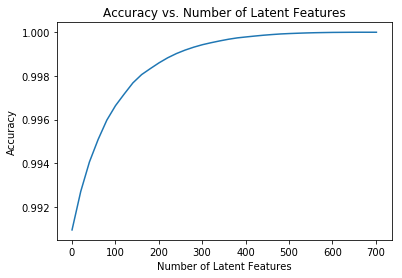

In [155]:
#Plot results
plt.plot(np.arange(1, len(s)-10, 20), 1 - np.array(accuracies));
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many movies can we make predictions for in the test set?  
* How many movies are we not able to make predictions for because of the cold start problem?

In [143]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # Your code here
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    test_idx = np.array(user_item_test.index.values)
    test_arts = np.array(user_item_test.columns.values)
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [144]:
user_item.shape, user_item_train.shape, user_item_test.shape

((5149, 714), (4487, 714), (682, 574))

In [145]:
# Users in the test set that are not in the training set
train_idx = np.array(user_item_train.index.values)
users_cold = np.setdiff1d(test_idx, train_idx).size
print("There are {} users in the test set we cannot make prediction because of the cold start problem".format(users_cold))
# articles in the test set that are not in the training set
train_arts = np.array(user_item_train.columns.values)
articles_cold = np.setdiff1d(test_arts, train_arts).size
print("There are {} articles in the test set we cannot make prediction because of the cold start problem".format(articles_cold))

There are 662 users in the test set we cannot make prediction because of the cold start problem
There are 0 articles in the test set we cannot make prediction because of the cold start problem


In [146]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many movies can we make predictions for in the test set?': b,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?': d # letter here
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find **U**, **S**, and **V** transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [147]:
# fit SVD on the user_item_train matrix
#u_train, s_train, vt_train = np.linalg.svd(user_item_train)
u_train, s_train, vt_train = fit(user_item_train)
# fit svd similar to above then use the cells below

In [148]:
u_train.shape, s_train.shape, vt_train.shape

((4487, 4487), (714,), (714, 714))

In [149]:
# Find the subset of rows in the user_item_test dataset that you can predict using this matrix decomposition
users_we_can_test = np.intersect1d(test_idx, train_idx)
#print(users_we_can_test)
user_item_test_we_can_predict = user_item_test.loc[users_we_can_test, test_arts]
user_item_test_we_can_predict.shape

(20, 574)

So we now have the user_item dataframe for the 20 users we can make preductions for (users in the test set who are also in the train set) and the articles we can predict (articles in the test set who are also in the test set).

In [150]:
# find the subset of user and article matrices that could be calculated by dot products.
u_test = u_train[user_item_train.index.isin(test_idx), :]
vt_test = vt_train[:, user_item_train.columns.isin(test_arts)]
s_test = s_train
u_test.shape, s_test.shape, vt_test.shape

((20, 4487), (714,), (714, 574))

We can now run the predictions on training and test set and compare the accuracy

In [157]:
train_accs = predict(user_item_train, u_train, s_train, vt_train)
test_accs = predict(user_item_test_we_can_predict, u_test, s_test, vt_test)

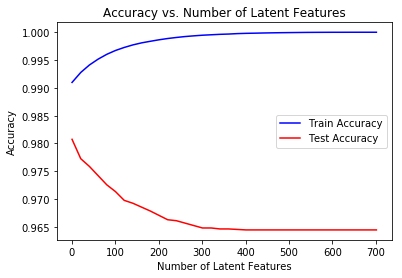

In [160]:
num_latent_feats = np.arange(1, 710, 20)
plt.plot(num_latent_feats, 1 - np.array(train_accs), color='b', label='Train Accuracy');
plt.plot(num_latent_feats, 1 - np.array(test_accs), color='r', label='Test Accuracy');
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');
plt.legend();
#plt.axhline(y=min_error, color='r', linestyle='-')
#plt.axvline(x=opt_latent_feats, color='g', linestyle='-')
#print("MSE is below {} with {} latent features".format(min_error, opt_latent_feats))

Doesn't look great. The problem could be that using accuracy to compare the results when the data is skewed, like there are much more zeros' than ones, and in the test dataset where we have only 20 users, is not the best. We will try and use the F1 score (an harmonic average of precision and recall) instead, then precision and recall and maybe we can get more information.


In [161]:
# Using F1 score instead of accuracy
from sklearn.metrics import f1_score, precision_recall_fscore_support

def predict_f1(user_item_matrix, u, s, vt):
    """
    INPUT:
        user_item_matrix - matrix with grouth truth values
        u -  u matrix from svd
        s -  s array from svd
        vt - v transpose matrix from svd
    
    OUTPUT: 
        f1_list - array of f1 scores for each step with k latent features
        precision_list - array of precicion scores for each step with k latent features
        recall_list - array of recall scores for each step with k latent features
    
    Description
        Test svd on the user item matrix using progressively increasing number of latent features
        and add the f1 score, precision and recall to the output lists
    
    """   
    
    max_latent_features = len(s) - 10
    num_latent_feats = np.arange(1, max_latent_features, 20)
    f1_list = []
    precision_list = []
    recall_list = []
    
    for k in num_latent_feats:
        s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
        # take dot product
        user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
        # compute error for each prediction to actual value
        y_true = np.array(user_item_matrix.values).reshape(user_item_matrix.size)
        y_pred = np.array(user_item_est.reshape(user_item_est.size))
        precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
        
        f1_list.append(f1_score)
        precision_list.append(precision)
        recall_list.append(recall)
    
    return f1_list, precision_list, recall_list
        
train_f1, train_prec, train_recall = predict_f1(user_item_train, u_train, s_train, vt_train)
test_f1, test_prec, test_recall = predict_f1(user_item_test_we_can_predict, u_test, s_test, vt_test)

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


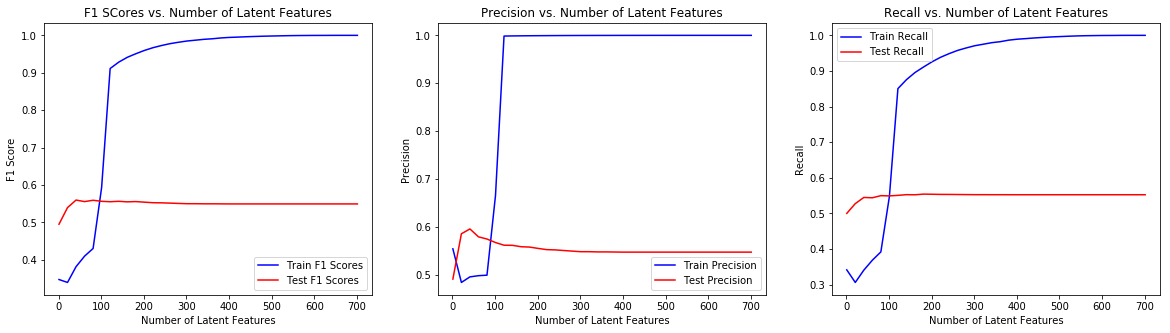

In [162]:
fig = plt.figure(figsize=(20, 5))

plt.subplot(1, 3, 1)
plt.plot(num_latent_feats, np.array(train_f1), color='b', label='Train F1 Scores');
plt.plot(num_latent_feats, np.array(test_f1), color='r', label='Test F1 Scores');
plt.xlabel('Number of Latent Features');
plt.ylabel('F1 Score');
plt.title('F1 SCores vs. Number of Latent Features');
plt.legend();

plt.subplot(1, 3, 2)
plt.plot(num_latent_feats, np.array(train_prec), color='b', label='Train Precision');
plt.plot(num_latent_feats, np.array(test_prec), color='r', label='Test Precision');
plt.xlabel('Number of Latent Features');
plt.ylabel('Precision');
plt.title('Precision vs. Number of Latent Features');
plt.legend();

plt.subplot(1, 3, 3)
plt.plot(num_latent_feats, np.array(train_recall), color='b', label='Train Recall');
plt.plot(num_latent_feats, np.array(test_recall), color='r', label='Test Recall');
plt.xlabel('Number of Latent Features');
plt.ylabel('Recall');
plt.title('Recall vs. Number of Latent Features');
plt.legend();

plt.show()

In [179]:
num_latent_feats

array([  1,  21,  41,  61,  81, 101, 121, 141, 161, 181, 201, 221, 241,
       261, 281, 301, 321, 341, 361, 381, 401, 421, 441, 461, 481, 501,
       521, 541, 561, 581, 601, 621, 641, 661, 681, 701])

In [190]:
# So for example with 101 latent features (k=5) we have:

test_f1[5], test_prec[5], test_recall[5]
print("# of datapoints in the test dataset",user_item_test_we_can_predict.size )
print("# of interactions in the test dataset",user_item_test_we_can_predict.sum().sum())
print("F1 score {:2f} , Precision {:2f}, Recall {:2f}".format(test_f1[5], test_prec[5], test_recall[5]))

# of datapoints in the test dataset 11480
# of interactions in the test dataset 218.0
F1 score 0.556376 , Precision 0.566904, Recall 0.549052


### Assessment predicted vs actual values
The graph above shows F1 score much lower for the test set, reaching the best values around k=100 latent features 
and beyond that the model just overfits the training data. If we look at precision and recall separately, we reach the same conclusion. A 0.549 recall means that out of 218 interactions in the test dataset the algorithm can predict only 120 of them, while 0.56 precsion means that only over half of the interactions predictions are correct. That doesn't give us the confidence we can make good predictions, so I would not consider this method here to make predictions in this case.

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

### Final Comments
The Collaborative filtering algorithm has instead showed it can make at least 10 predictions even for user with only one interaction so I would prefer it in this application, especially in the modified version that chooses the users that have the most total article interactions before choosing those with fewer article interactions and chooses articles with the articles with the most total interactions before choosing those with fewer total interactions. 
This can eventually be integrated with the algorithm that captures similarities between articles, although the risk here is that the user could be become bored if he gets recommended items that are too similar to each other. I would use this one only in case the collaborative filtering algorithm doesn't give enough results.


In [1]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

0